# Installation des packages

In [6]:
# For faster package installation
options(repos=list(CRAN='https://packagemanager.posit.co/cran/__linux__/jammy/latest/'))

# Install DiceDesign, DiceKriging and DiceEval
install.packages(c("DiceDesign","DiceKriging","DiceEval"))
library(DiceDesign)
library(DiceKriging)
library(DiceEval)

# Install MASS (for sampling GPs)
install.packages("MASS")
library(MASS)

# Install GSL package
system("sudo apt install libgsl-dev")
install.packages("copula")
library(copula)

# Install nestedKriging package
remotes::install_url("https://github.com/drulliere/nestedKriging/raw/refs/heads/master/nestedKriging_0.2.2.tar.gz")
library(nestedKriging)

# Install combinedkriging
remotes::install_github("TAppriou/combinedkriging", upgrade="never")
library(combinedkriging)


Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)





── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/Rtmp5YsWr9/remotes91d91291312b/nestedKriging/DESCRIPTION’ ... OK
* preparing ‘nestedKriging’:
* checking DESCRIPTION meta-information ... OK
* cleaning src
* installing the package to process help pages
* saving partial Rd database
* cleaning src
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘nestedKriging_0.2.2.tar.gz’



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Skipping install of 'combinedkriging' from a github remote, the SHA1 (fb20b5e8) has not changed since last install.
  Use `force = TRUE` to force installation



 # Exemple simple en 2D

 On veut construire un métamodèle de la fonction :
 $$ f_{Branin}(x_1,x_2)= \left(x_2 - \frac{5.1x_1^2}{4\pi^2} + \frac{5}{\pi x_1} - 6\right)^2 + 10\left(1 - \frac{1}{8\pi}\right)\cos(x_1) + 10 + 5\frac{x_1+5}{15}, \\ \text{with} -5\leq x_1\leq 10, \quad 0\leq x_2\leq 15. $$

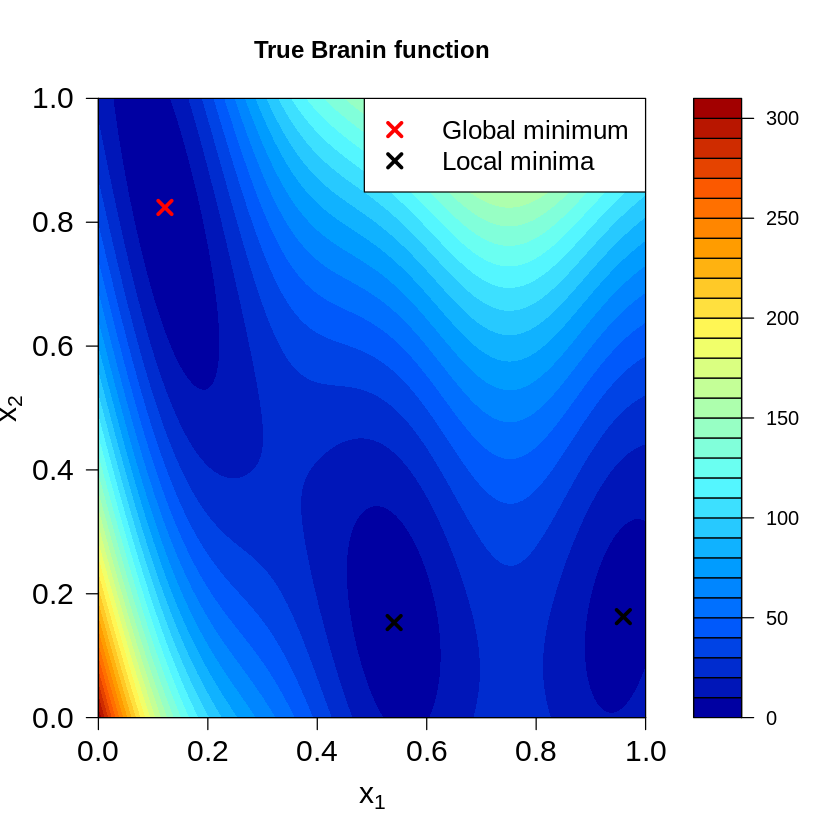

In [2]:
# Branin function (input normalized between 0 and 1)

f_branin <- function(X) {
  if (!is.matrix(X)) X <- matrix(X,ncol=2) #Transform X into a matrix if it is a vector
  if (ncol(X) != 2) {
    if (nrow(X) != 2) stop(paste("The dimension must be ", 2))
    else X <- t(X)
  }
  x1 <- X[,1]*15 - 5
  x2 <- X[,2]*15
  res <- (x2 - 5.1/(4*pi^2) * (x1^2) + 5/pi*x1 - 6)^2 + 10*(1 - 1/(8*pi))*cos(x1) + 10 + 5*(x1+5)/15
  return(res)
}


# Plot the true Branin function on a grid

neval <- 201 #Number of points for plot is neval^d
X_grid <- as.matrix(expand.grid(seq(0,1,length.out=neval), seq(0,1,length.out=neval)))
Y_true <- f_branin(X_grid)
min_glob_branin <- c(-3.1762, 12.3582) #Global minimum of the Branin function
min_glob_branin <- (min_glob_branin + c(5,0))/15 #Normalization of the minima
min_loc_branin <- matrix(c(3.1069, 2.3023, 9.3901, 2.4461), nrow=2, ncol=2, byrow=TRUE) #Local minima of the Branin function
min_loc_branin <- (min_loc_branin + matrix(c(5,0),2,2,byrow=TRUE))/15 #Normalization of the minima

palette <- colorRampPalette(c("#0000A2", "#0017B9", "#002ED1", "#0046E8", "#005DFF", "#0074FF", "#008BFF", "#00A2FF", "#17B9FF", "#2ED1FF", "#46E8FF", "#5DFFFF", "#74FFE8", "#8BFFD1", "#A2FFB9", "#B9FFA2", "#D1FF8B", "#E8FF74", "#FFFF5D", "#FFE846", "#FFD12E", "#FFB917", "#FFA200", "#FF8B00", "#FF7400", "#FF5D00", "#E84600", "#D12E00", "#B91700", "#A20000"))

filled.contour(matrix(Y_true, neval, neval), xlim=0:1, ylim=0:1, nlevels=30, color.palette = palette,
               xlab=expression(x[1]), ylab=expression(x[2]), main="True Branin function",
               plot.axes={axis(1,cex.axis=1.5); axis(2,cex.axis=1.5); points(t(min_glob_branin), pch=4, cex=1.5, lwd=3, col="red");
                 points(min_loc_branin, pch=4, cex=1.5, lwd=3, col="black");
                 legend("topright", legend=c("Global minimum","Local minima"), pch=rep(4,2), lty=rep(NA,2), pt.cex=rep(1.5,2), lwd=rep(3,2), col=c("red","black"), cex=1.3, bg="white")},  cex.lab=1.5)


# Metamodel with Ordinary Kriging

Hypothèse de Krigeage classique : $y(\cdot)$ est la réalisation d'un processus Gaussien :

$$Y(\cdot) \sim \mathcal{GP} \left(\mu,k_{\theta}(\cdot,\cdot) \right).$$

On se donne un plan d'expérience LHS : $\mathcal{D}=(X,Y)$.

Le métamodèle est donné par la moyenne de Krigeage :

$$\hat{y}(x) = E(Y(x) \vert \mathcal{D}) = \mu+ k_{\theta}(x,X)k_{\theta}(X,X)^{-1}(Y-\mu),$$

où les hyperparamètres sont estimés par maximum de vraissemblance.

[1] "MLE Lengh-scales :"
[1] 0.4441768 1.0601219
[1] "R2 : 0.970359077041154"


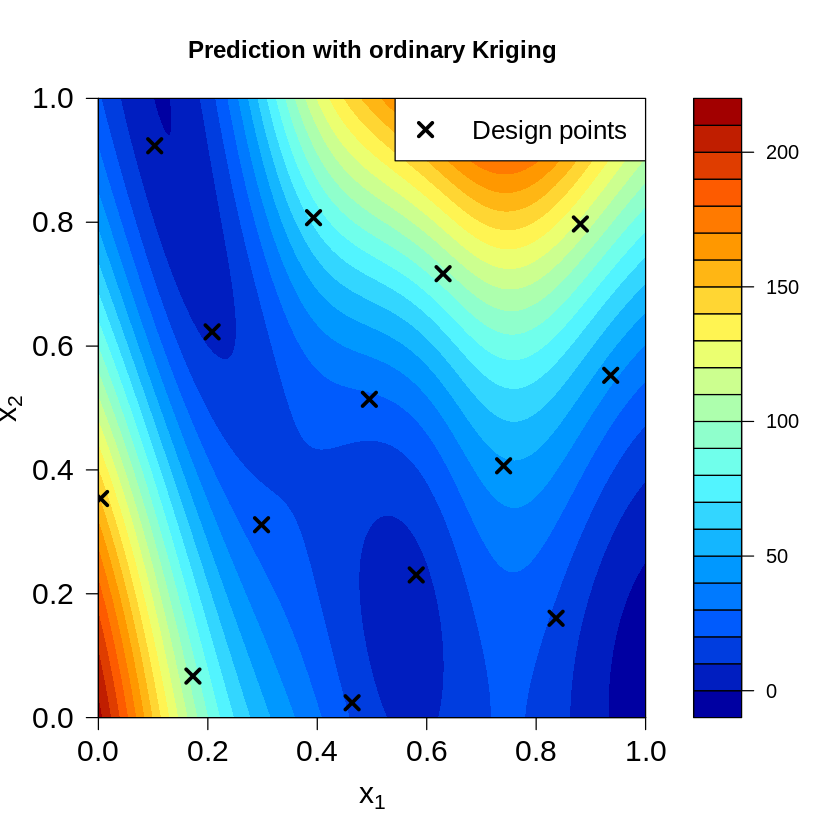

In [4]:
seed_init <- 123 #Random seed
set.seed(123)

d <- 2 #Dimension
n_train <- 15 #Number of training samples

X_train <- lhsDesign(n=n_train, dimension=d, seed=seed_init)$design #LHS
X_train <- maximinESE_LHS(X_train)$design #Optimize the LHS

Y_train <- f_branin(X_train) # Function values at the training points

# Build the Kriging model
krg_model <- krg_MLE(X_train=X_train, Y_train=Y_train, bornes_opt=c(0.01,3),
                     kernel="matern5_2", theta_init=NULL, estim_mean=TRUE, nugget=NULL)

# Prediction on the grid using the model
Y_pred_krg <- pred_krg(X_test=X_grid, model=krg_model)$mean

# Plot
filled.contour(matrix(Y_pred_krg, neval, neval), xlim=0:1, ylim=0:1, nlevels=30, color.palette = palette,
               xlab=expression(x[1]), ylab=expression(x[2]), main="Prediction with ordinary Kriging",
               plot.axes={axis(1,cex.axis=1.5); axis(2,cex.axis=1.5); points(X_train, pch=4, cex=1.5, lwd=3, col="black");
                 legend("topright", legend=c("Design points"), pch=rep(4,1), lty=rep(NA,1), pt.cex=rep(1.5,1), lwd=rep(3,1), col=c("black"), cex=1.3, bg="white")}, cex.lab=1.5)

print("MLE Lengh-scales :")
print(krg_model$theta)

# Function to compute the R2 coefficient
compute_R2 <- function(Y_pred, Y_test) {
  return( 1 - sum((Y_pred - Y_test)^2)/sum((Y_test-mean(Y_test))^2) )
}

print(paste("R2 :", compute_R2(Y_pred_krg, Y_true)))

# Metamodel with combinations

La combinaison est donnée par :

$$M_{comb}=\sum_{i=1}^p w_i(x)M_i(x),$$

$$\text{avec} \ M_i(x)= \mu_i+ k_{\theta_i}(x,X)k_{\theta_i}(X,X)^{-1}(Y-\mu_i).$$

Dans ce cas en 2D, on construit des sous-modèles sur une grille de portées :

$$\theta_{list} = \{0.1, 0.5, 1, 1.5\}\times \{0.1, 0.5, 1, 1.5\}$$.

On a donc $p=16$ sous-modèles dans la combinaison.

Plusieurs méthodes possibles pour les poids $w_i$ :

- Produit d'experts (PoE),
- Produit d'experts généralisé (gPoE),
- Mixture d'experts (MoE),
- Validation croisée Leave-one-out (LOO),
- LOOCV diagonal (diagLOO),
- LOOCV binaire (binLOO).

   Theta1 Theta2      Weights
1     0.1    0.1 9.330290e-03
2     0.5    0.1 1.331074e-03
3     1.0    0.1 4.654022e-05
4     1.5    0.1 4.116521e-06
5     0.1    0.5 1.037286e-02
6     0.5    0.5 2.520236e-01
7     1.0    0.5 2.289921e-03
8     1.5    0.5 1.666187e-05
9     0.1    1.0 7.914935e-04
10    0.5    1.0 3.381603e-01
11    1.0    1.0 4.894171e-02
12    1.5    1.0 2.314795e-03
13    0.1    1.5 1.412950e-04
14    0.5    1.5 2.877947e-01
15    1.0    1.5 3.994196e-02
16    1.5    1.5 6.498758e-03
[1] "R2 : 0.957608524875292"


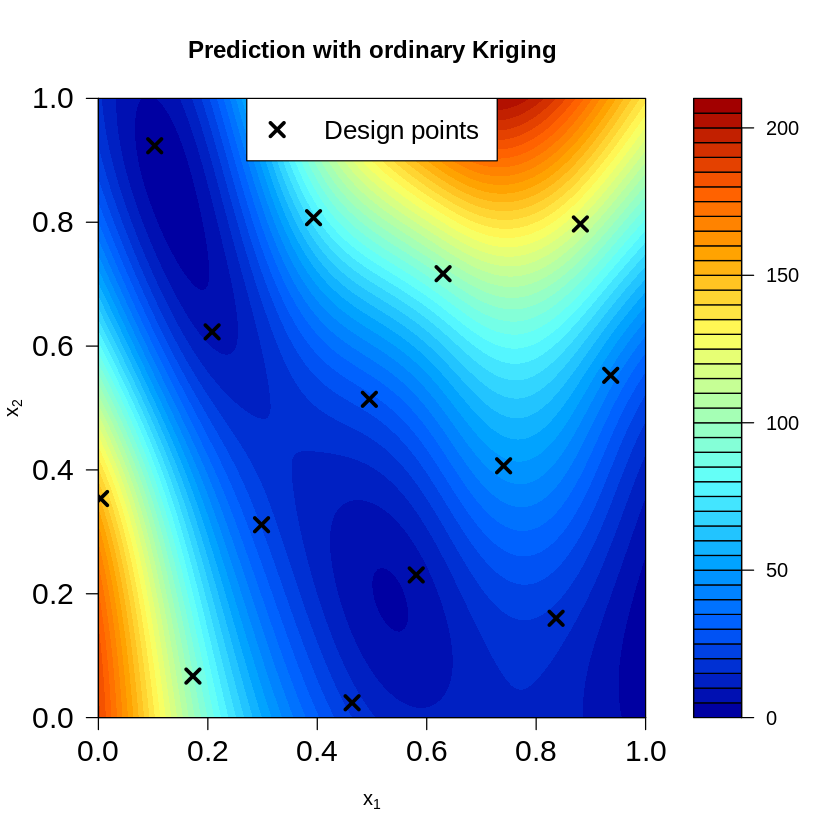

In [5]:
# Length-scales of the sub-models
theta_grid <- c(0.1,0.5,1,1.5)
theta_list <- as.matrix(expand.grid(theta_grid, theta_grid))

# Build the combination

# weighting_method == "MoE", "PoE", "gPoE", "LOO" or "diagLOO"
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                         kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="MoE")
Y_pred_comb <- pred_comb_mean(X_test=X_grid, model=model_comb)$mean

# # weighting_method == "binLOO"
# model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
#                            kernel="matern5_2", n_tree_levels=5, estim_mean=TRUE, nugget=0, weighting_method="binLOO")
# Y_pred_comb <- pred_comb(X_test=X_grid, model=model_comb)$mean

# Plot
filled.contour(matrix(Y_pred_comb, neval, neval), xlim=0:1, ylim=0:1, nlevels=30, color.palette = palette,
               xlab=expression(x[1]), ylab=expression(x[2]), main="Prediction with ordinary Kriging",
               plot.axes={axis(1,cex.axis=1.5); axis(2,cex.axis=1.5); points(X_train, pch=4, cex=1.5, lwd=3, col="black");
                 legend("top", legend=c("Design points"), pch=rep(4,1), lty=rep(NA,1), pt.cex=rep(1.5,1), lwd=rep(3,1), col=c("black"), cex=1.3, bg="white")})

# Print weights
print_w <- data.frame("Theta1"=theta_list[,1], "Theta2"=theta_list[,2], "Weights"=model_comb$beta_list)
print(print_w)

# Print R2
print(paste("R2 :", compute_R2(Y_pred_comb, Y_true)))

# Essayer avec moins de points

Essayer les deux sections précédentes avec $n_{train}=10$ sample points.

# Exemple en dimension supérieure : sous-modèles isotropes

On se place en dimension $d=50$.

La fonction test sera une trajectoire de processus Gaussien de portée connue. Dans cet exemple : $\theta_{true}=2$ dans chaque dimension (isotrope).

$$Y_{iso}(\cdot) \sim \mathcal{GP} \left(0,k_{\theta_{true}}(\cdot,\cdot) \right).$$

Les portées des sous-modèles (isotropes ici) seront :

$$\theta_{list}=\{1, 1.5, 2, 2.5, 3, 4, 6, 8\}$$.

- Nombre de points d'apprentissage : $n_{train}=500$
- Nombre de points tests : $n_{test}=2000$

On compare comment les différentes combinaisons pondèrent les sous-modèles. Parvient-on à retouver le vrai modèle avec $\theta=\theta_{true}=2$.

## Échantillonage trajectoire

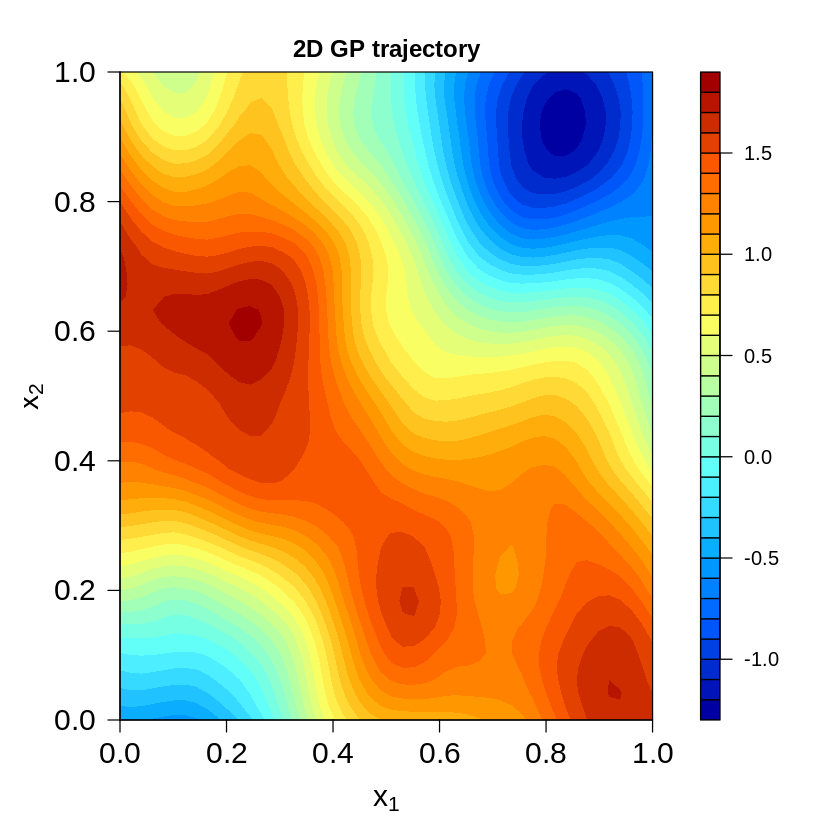

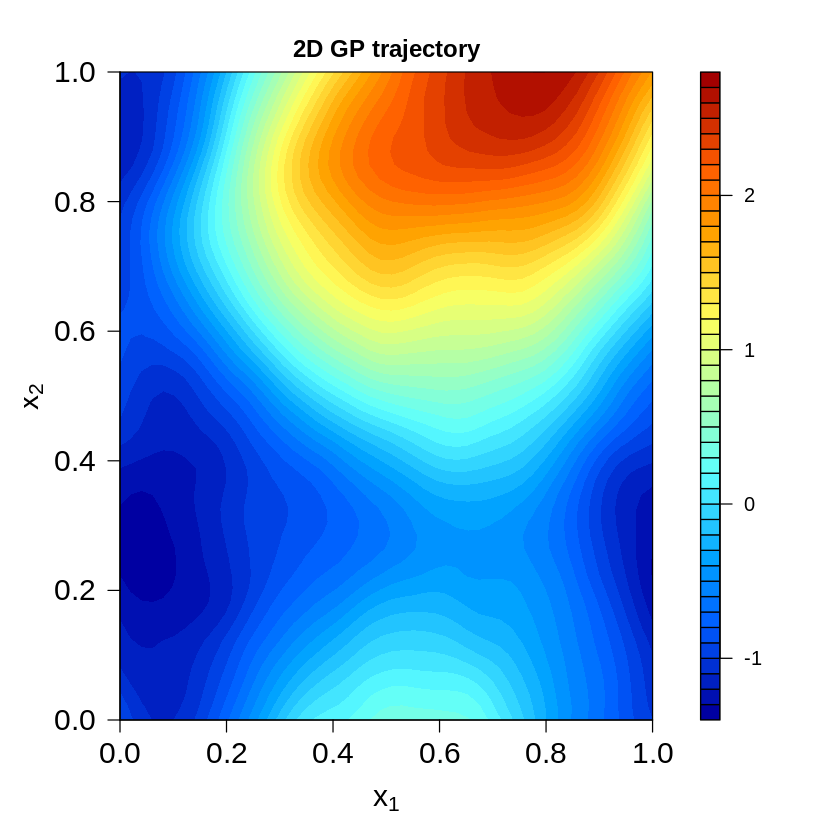

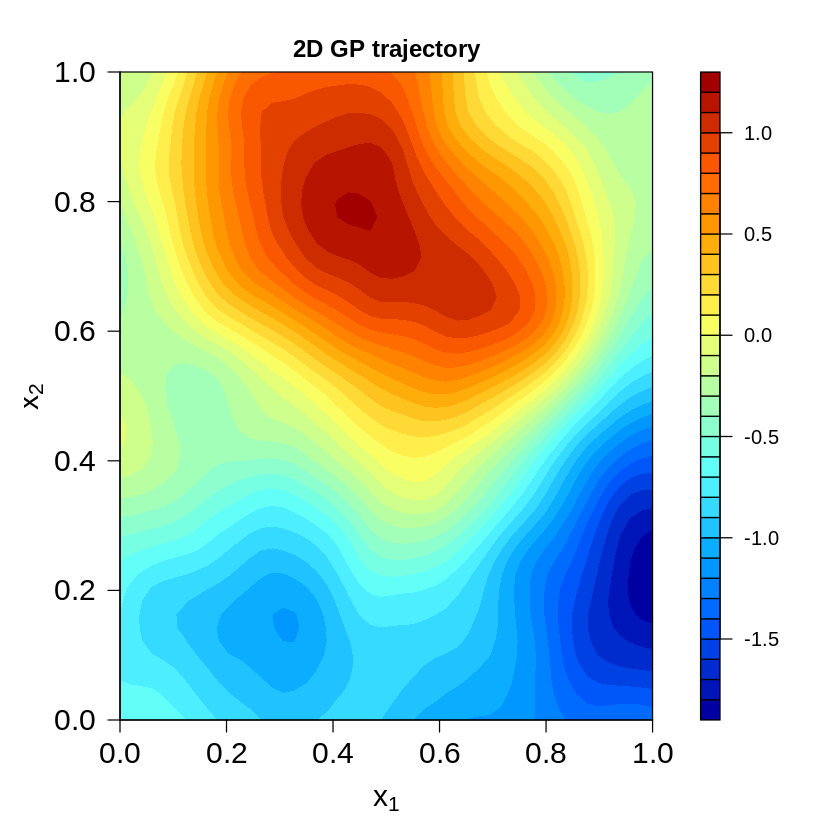

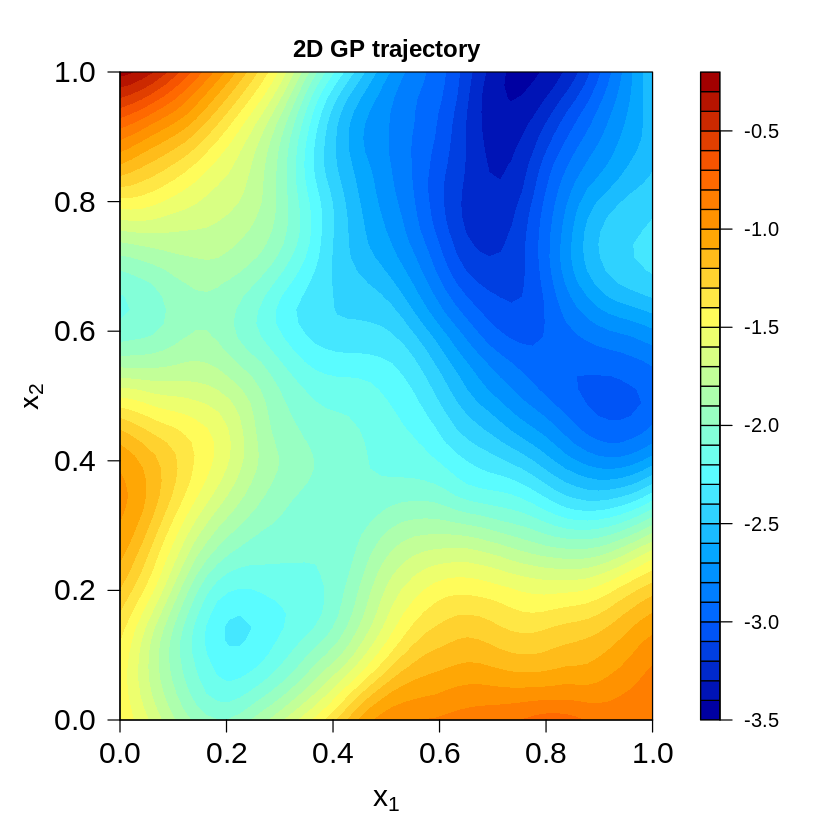

In [32]:
set.seed(124) #Random seed

d <- 50 #Dimension
n_train <- 500 #Number of training samples
n_test <- 2000 #Number of test samples
theta_true <- 2 #True length-scale

# Isotropic sub-models
list_iso <- c(1,1.5,2,2.5,3,4,6,8)
theta_list <- matrix(0, nrow=8, ncol=d)
for (i in 1:8) {
  theta_list[i,] <- rep(list_iso[i],d)
}

# Training points
X_train <- lhsDesign(n=n_train, dimension=d)$design #LHS

# Test points
X_test <- matrix(0,nrow=n_test,ncol=d)
for (i in 1:n_test) {
  X_test[i,] <- runif(d, min=0, max=1)
}

# Sampling of the GP trajectory
X_tot <- rbind(X_train,X_test)
K_tot <- nestedKriging::getCorrMatrix(X_tot, rep(theta_true,d), "matern5_2.radial")
Y_tot <- mvrnorm(1, mu = rep(0,n_train+n_test), Sigma = K_tot)
Y_train <- Y_tot[1:n_train]
Y_test <- Y_tot[(n_train+1):(n_train+n_test)]

# Plot 2D examples
n_plot <- 50
X_plot <- as.matrix(expand.grid(seq(0,1,length.out=n_plot), seq(0,1,length.out=n_plot)))
theta_plot <- sqrt(2/12)
K <- nestedKriging::getCorrMatrix(X_plot, rep(theta_plot,2), "matern5_2.radial")
Y_plot_list <- mvrnorm(4, mu = rep(0,n_plot^2), Sigma = K)
palette <- colorRampPalette(c("#0000A2", "#0017B9", "#002ED1", "#0046E8", "#005DFF", "#0074FF", "#008BFF", "#00A2FF", "#17B9FF", "#2ED1FF", "#46E8FF", "#5DFFFF", "#74FFE8", "#8BFFD1", "#A2FFB9", "#B9FFA2", "#D1FF8B", "#E8FF74", "#FFFF5D", "#FFE846", "#FFD12E", "#FFB917", "#FFA200", "#FF8B00", "#FF7400", "#FF5D00", "#E84600", "#D12E00", "#B91700", "#A20000"))
par(mfrow=c(2,2))
for (i in 1:4) {
  filled.contour(matrix(Y_plot_list[i,], n_plot, n_plot), xlim=0:1, ylim=0:1, nlevels=30, color.palette = palette,
               xlab=expression(x[1]), ylab=expression(x[2]), main="2D GP trajectory",
               plot.axes={axis(1, cex.axis=1.5); axis(2, cex.axis=1.5)}, cex.lab=1.5)

}




## Vrai modèle (avec $\theta_{true}$) et combinaisons

In [28]:
# True model
krg_model_true <- km(design=X_train, response=Y_train, covtype="matern5_2", coef.trend=0, coef.cov=rep(theta_true,length=d), coef.var=1, control=list(trace=FALSE))
prediction_krg_true <- predict.km(krg_model_true,X_test,"SK",checkNames=FALSE)
Y_pred_krg_true <- prediction_krg_true$mean
R2_true <- compute_R2(Y_pred_krg_true, Y_test)
print(paste("R2 true model :", R2_true))

# PoE
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="PoE")
Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
w_PoE <- model_comb$beta_list #Weight of sub-models
R2_PoE <- compute_R2(Y_pred_comb, Y_test) #R2

# gPoE
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="gPoE")
Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
w_gPoE <- model_comb$beta_list #Weight of sub-models
R2_gPoE <- compute_R2(Y_pred_comb, Y_test) #R2

# MoE
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="MoE")
Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
w_MoE <- model_comb$beta_list #Weight of sub-models
R2_MoE <- compute_R2(Y_pred_comb, Y_test) #R2

# LOOCV
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="LOO")
Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
w_LOO <- model_comb$beta_list #Weight of sub-models
R2_LOO <- compute_R2(Y_pred_comb, Y_test) #R2

# Diagonal LOOCV
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="diagLOO")
Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
w_diagLOO <- model_comb$beta_list #Weight of sub-models
R2_diagLOO <- compute_R2(Y_pred_comb, Y_test) #R2

# Binary LOOCV
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, n_tree_levels=4, weighting_method="binLOO")
Y_pred_comb <- pred_comb(X_test=X_test, model=model_comb)$mean
w_binLOO <- model_comb$beta_list #Weight of sub-models
R2_binLOO <- compute_R2(Y_pred_comb, Y_test) #R2

# Print weights and R2
print("Weights")
print(data.frame("Length-scale"=list_iso, "PoE"=w_PoE, "gPoE"=w_gPoE, "MoE"=w_MoE, "LOO"=w_LOO, "diagLOO"=w_diagLOO, "binLOO"=w_binLOO))
print("R2")
print(data.frame("True"=R2_true, "PoE"=R2_PoE, "gPoE"=R2_gPoE, "MoE"=R2_MoE, "LOO"=R2_LOO, "diagLOO"=R2_diagLOO, "binLOO"=R2_binLOO))

[1] "R2 true model : 0.348787776620046"
[1] "Weights"
  Length.scale PoE         gPoE          MoE          LOO   diagLOO     binLOO
1          1.0   1 0.9704839389 2.518603e-08     1.249191 0.1181611 0.00000000
2          1.5   1 0.0053026102 9.089001e-01  -176.831014 0.1273410 0.19176239
3          2.0   1 0.0121183376 9.095331e-02  2238.278223 0.1281528 0.49603427
4          2.5   1 0.0009548100 1.464093e-04 -8828.183181 0.1277754 0.08211249
5          3.0   1 0.0006467247 1.320072e-07 11831.900125 0.1271455 0.23009085
6          4.0   1 0.0000000000 3.128072e-13 -7386.538939 0.1258137 0.00000000
7          6.0   1 0.0000000000 4.773840e-22  3404.630959 0.1236058 0.00000000
8          8.0   1 0.0104935786 1.373161e-28 -1083.505364 0.1220046 0.00000000
[1] "R2"
       True       PoE      gPoE       MoE       LOO   diagLOO    binLOO
1 0.3487878 0.3013129 0.3375018 0.3404258 0.3284084 0.3451285 0.3491305


# Même exemple, mais les sous-modèles ne sont plus isotropes

Cette fois, les sous-modèles ne sont plus isotropes.

On calcule d'abord des bornes pour échantillonner les portées :

$$[\theta^{(\ell)}_{min},\theta^{(\ell)}_{max}], \quad \ell=1,\dots,d.$$

On échantillonne ensuite avec une des 3 méthodes :

- Échnatillonnage uniforme
- Échantillonnage avec des copules de Gumbel,
- Échantillonnage avec l'entropie des corrélations.

In [24]:
# Lower and upper bounds for sampling the length-scales
bounds_comb <- bornes_theta(d=d, X=X_train, kernel="matern5_2")

print("Length-scale bounds (first 10 dimensions)")
print(bounds_comb[1:10,])

n_comb_max <- 128 #Number of sub-models

# Sampling the length-scales (uniform)
theta_list_unif <- sample_theta_unif(d=d, n_comb=n_comb_max, bornes=bounds_comb)

# Sampling the length-scales (copula)
theta_list_copula <- sample_theta_copula(d=d, n_comb=n_comb_max, bornes=bounds_comb, param_copula=2)

# Sampling the length-scales (entropy)
theta_list_entropy <- sample_theta_entropy(X=X_train, n_comb=n_comb_max, bornes=bounds_comb, kernel="matern5_2", iso=TRUE)


[1] "Length-scale bounds (first 10 dimensions)"
           [,1]     [,2]
 [1,] 0.5446316 8.128879
 [2,] 0.5447156 8.130133
 [3,] 0.5446278 8.128823
 [4,] 0.5446573 8.129263
 [5,] 0.5446110 8.128572
 [6,] 0.5445344 8.127430
 [7,] 0.5446135 8.128610
 [8,] 0.5446018 8.128436
 [9,] 0.5446609 8.129317
[10,] 0.5445705 8.127968


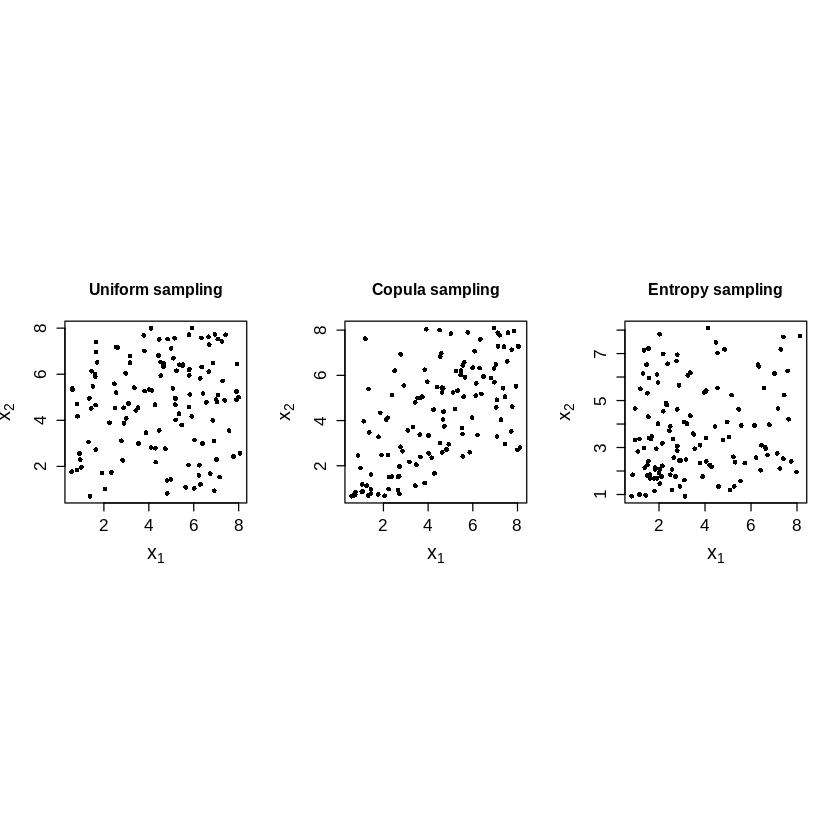

In [15]:
# Plot on on two dimensions
d1 <- 1
d2 <- 2
par(mfrow=c(1,3), pty="s")
plot(theta_list_unif[,d1], theta_list_unif[,d2],
     xlab=expression(x[1]), ylab=expression(x[2]), pch=16, cex=0.8, cex.axis=1.3, cex.lab=1.5, main="Uniform sampling")

plot(theta_list_copula[,d1], theta_list_copula[,d2],
     xlab=expression(x[1]), ylab=expression(x[2]), pch=16, cex=0.8, cex.axis=1.3, cex.lab=1.5, main="Copula sampling")

plot(theta_list_entropy[,d1], theta_list_entropy[,d2],
     xlab=expression(x[1]), ylab=expression(x[2]), pch=16, cex=0.8, cex.axis=1.3, cex.lab=1.5, main="Entropy sampling")

# On fait varier le nombre de sous-modèles

## D'abord Krigeage ordinaire pour comparaison

Le nombre d'itérations max dans l'optimisation est fixé à 300 (pas de restart).

In [25]:
# Kriging model
time1 <- Sys.time()
krg_model <- krg_MLE(X_train=X_train, Y_train=Y_train, bornes_opt=c(0.1,20),
                     kernel="matern5_2", theta_init=NULL, estim_mean=TRUE, nugget=NULL)
time2 <- Sys.time()
time_est_krg <- difftime(time2,time1,units="secs")
print(paste("Time estimation OK :", time_est_krg))

# Prediction
time3 <- Sys.time()
prediction_krg <- pred_krg(X_test=X_test, model=krg_model)
time4 <- Sys.time()
time_pred_krg <- difftime(time4,time3,units="secs")
print(paste("Time prediction OK :", time_pred_krg))

# Length-scales
print("MLE length-scales :")
print(krg_model$theta)

# R2
R2_krg <- compute_R2(prediction_krg$mean, Y_test)
print(paste("R2 OK :", R2_krg))

[1] "Time estimation OK : 228.802282094955"
[1] "Time prediction OK : 0.154465198516846"
[1] "MLE length-scales :"
 [1]  2.4616453  1.6886592  1.9941342 12.9856346 18.3122629  1.4421848
 [7] 11.3000633  2.6274834  1.7025785 15.2674796  2.9894080  2.9970749
[13]  1.3841162  2.1614442  1.3926878 20.0000000  7.2705697  2.2206801
[19]  1.3114259 20.0000000  2.6986607  2.4668236  2.6072650 18.7769160
[25]  1.6881062  3.4933725  3.8188428  0.8204814  3.3725085 20.0000000
[31] 18.3849986  3.6666572  3.1592198  2.3531786  1.2112269 15.2501589
[37]  2.1373559  1.8635655 20.0000000  2.7609773  1.6385464 20.0000000
[43]  1.5094650  1.6051172  2.5366339  1.4842827  3.1476561  4.6612534
[49]  4.1619579  3.8582212
[1] "R2 OK : 0.28263307752082"


## Ensuite les combinaisons.

On fait varier le nombre de sous-modèles 5 par 5, de 5 à 40 :

$$p\in\{5,10,15,20,25,30,35,40\}$$

Pour la méthode binLOO :

$$p\in\{4,8,16,32\}$$

In [20]:
n_termes <- seq(5,40,by=5) #Number of sub-models
n_termes_bin <- c(3,4,5,6) # For the binLOO method

# Initialization of outputs (time combination, time prediction and R2)
time_comb_PoE <- rep(NA, length=length(n_termes))
time_pred_PoE <- rep(NA, length=length(n_termes))
R2_PoE <- rep(NA, length=length(n_termes))
time_comb_gPoE <- rep(NA, length=length(n_termes))
time_pred_gPoE <- rep(NA, length=length(n_termes))
R2_gPoE <- rep(NA, length=length(n_termes))
time_comb_MoE <- rep(NA, length=length(n_termes))
time_pred_MoE <- rep(NA, length=length(n_termes))
R2_MoE <- rep(NA, length=length(n_termes))
time_comb_LOO <- rep(NA, length=length(n_termes))
time_pred_LOO <- rep(NA, length=length(n_termes))
R2_LOO <- rep(NA, length=length(n_termes))
time_comb_diagLOO <- rep(NA, length=length(n_termes))
time_pred_diagLOO <- rep(NA, length=length(n_termes))
R2_diagLOO <- rep(NA, length=length(n_termes))
time_comb_binLOO <- rep(NA, length=length(n_termes_bin))
time_pred_binLOO <- rep(NA, length=length(n_termes_bin))
R2_binLOO <- rep(NA, length=length(n_termes_bin))

# Sample length-scales
bounds_comb <- bornes_theta(d=d, X=X_train, kernel="matern5_2")
theta_list_entropy <- sample_theta_entropy(X=X_train, n_comb=40, bornes=bounds_comb, kernel="matern5_2", iso=TRUE)

# Loop on number of sub-models
for (n_comb in n_termes) {

  ind <- which(n_termes == n_comb)

  theta_list <- theta_list_entropy[1:n_comb,]

  # PoE
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="PoE")
  time2 <- Sys.time()
  time_comb_PoE[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_PoE[ind] <- difftime(time4,time3,units="secs")
  R2_PoE[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

  # gPoE
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="gPoE")
  time2 <- Sys.time()
  time_comb_gPoE[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_gPoE[ind] <- difftime(time4,time3,units="secs")
  R2_gPoE[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

  # MoE
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="MoE")
  time2 <- Sys.time()
  time_comb_MoE[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_MoE[ind] <- difftime(time4,time3,units="secs")
  R2_MoE[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

  # LOOCV
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="LOO")
  time2 <- Sys.time()
  time_comb_LOO[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_LOO[ind] <- difftime(time4,time3,units="secs")
  R2_LOO[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

  # Diagonal LOOCV
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, weighting_method="diagLOO")
  time2 <- Sys.time()
  time_comb_diagLOO[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_diagLOO[ind] <- difftime(time4,time3,units="secs")
  R2_diagLOO[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

}

# For the binLOO method
for (n_tree_levels in n_termes_bin) {

  ind <- which(n_tree_levels == n_comb)

  n_comb <- 2^(n_tree_levels - 1)
  theta_list <- theta_list_entropy[1:n_comb,]

  # Binary LOOCV
  time1 <- Sys.time()
  model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, n_tree_levels=n_tree_levels, weighting_method="binLOO")
  time2 <- Sys.time()
  time_comb_binLOO[ind] <- difftime(time2,time1,units="secs")
  time3 <- Sys.time()
  Y_pred_comb <- pred_comb_mean(X_test=X_test, model=model_comb)$mean
  time4 <- Sys.time()
  time_pred_binLOO[ind] <- difftime(time4,time3,units="secs")
  R2_binLOO[ind] <- compute_R2(Y_pred_comb, Y_test) #R2

}

# Print results

print("R2")
print(paste("R2 for reference model", R2_true))
print(paste("R2 for OK", R2_krg))
print( data.frame("R2 PoE"=R2_PoE,
                  "R2 gPoE"=R2_gPoE,
                  "R2 MoE"=R2_MoE,
                  "R2 LOO"=R2_LOO,
                  "R2 diagLOO"=R2_diagLOO,
                  row.names=n_termes ))

print("Time for building the model")
print(paste("Time for MLE", time_est_krg))
print( data.frame("Time comb PoE"=time_comb_PoE,
                  "Time comb gPoE"=time_comb_gPoE,
                  "Time comb MoE"=time_comb_MoE,
                  "Time comb LOO"=time_comb_LOO,
                  "Time comb diagLOO"=time_comb_diagLOO,
                  row.names=n_termes ))

print("Time for prediction")
print(paste("Time for OK", time_pred_krg))
print( data.frame("Time pred PoE"=time_pred_PoE,
                  "Time pred gPoE"=time_pred_gPoE,
                  "Time pred MoE"=time_pred_MoE,
                  "Time pred LOO"=time_pred_LOO,
                  "Time pred diagLOO"=time_pred_diagLOO,
                  row.names=n_termes ))

[1] "R2"
[1] "R2 for reference model 0.37584876192051"
[1] "R2 for OK 0.221721275832037"


ERROR: Error in data.frame(`R2 PoE` = R2_PoE, `R2 gPoE` = R2_gPoE, `R2 MoE` = R2_MoE, : row names supplied are of the wrong length


## Intervalles de confiance

On vérifie aussi les intervalles de confiance prédit par le modèle (seulement disponible pour binLOO).

On compare les intervalles de confiance théoriques, à ceux obtenus empiriquement pour différents niveaux.

In [26]:
# Function to compute the coverage probability
compute_CP <- function(Y_test,Y_pred,var_pred,alpha) {
  n_test <- length(Y_test)
  res <- 0
  for (i in 1:n_test) {
    if (Y_pred[i]+qnorm(alpha/2)*sqrt(var_pred[i]) < Y_test[i] && Y_test[i] < Y_pred[i]+qnorm(1-alpha/2)*sqrt(var_pred[i])) {
      res <- res + 1
    }
  }
  return(res/n_test)
}

# Function to compute the coverage probability for varied proba
compute_CPs <- function(Y_test,Y_pred,var_pred,alpha_list) {
  res <- rep(0,length=length(alpha_list))
  for (i in 1:length(alpha_list)) {
    res[i] <- compute_CP(Y_test,Y_pred,var_pred,alpha_list[i])
  }
  return(res)
}

proba_list <- seq(0.05,0.5,by=0.05) #List of probas for computing the coverage probability

n_tree_levels <- 5
n_comb <- 2^(n_tree_levels - 1)
theta_list <- theta_list_entropy[1:n_comb,]
model_comb <- combined_krg(X_train=X_train, Y_train=Y_train, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0, n_tree_levels=n_tree_levels, weighting_method="binLOO")
prediction_comb <- pred_comb(X_test=X_test, model=model_comb)

# Combination
CPs_comb <- compute_CPs(Y_test, prediction_comb$mean, prediction_comb$var, proba_list)

# True model
CPs_true <- compute_CPs(Y_test, prediction_krg_true$mean, (prediction_krg_true$sd)^2, proba_list)

# Ordinary Kriging
CPs_krg <- compute_CPs(Y_test, prediction_krg$mean, prediction_krg$var, proba_list)

# Print
print("Coverage probabilities")
print(data.frame("Theoretical"=1-proba_list, "True model"=CPs_true, "OK"=CPs_krg, "Combination"=CPs_comb))

[1] "Coverage probabilities"
   Theoretical True.model     OK Combination
1         0.95     0.9620 0.8695      0.9365
2         0.90     0.9245 0.8045      0.8890
3         0.85     0.8785 0.7505      0.8360
4         0.80     0.8350 0.6975      0.7985
5         0.75     0.7945 0.6525      0.7470
6         0.70     0.7500 0.6020      0.7055
7         0.65     0.7150 0.5560      0.6615
8         0.60     0.6680 0.5025      0.6145
9         0.55     0.6170 0.4645      0.5605
10        0.50     0.5630 0.4195      0.5185


# Exemple pour de l'optimisation Bayésienne

On test de l'optimisation Bayésienne (EGO) avec la combinaison.

La fonction à optimiser est la fonction sphère :

$$f_{sphère}(x_1,\dots,x_d) = \sqrt{\sum_{\ell=1}^{d} \left(x_{\ell}-0.5 \right)^2}, \quad 0 \leq x_{\ell} \leq 1, \quad \ell = 1,\dots,d,$$

## D'abord en faible dimension

- $d=10$
- Nombre de points initiaux : $n_{train}=20$
- Nombre d'itérations EGO : $n_{iter}=50$ (peu d'itérations pour limiter le temps des tests)

Plot de la fonction sphère en 2D :

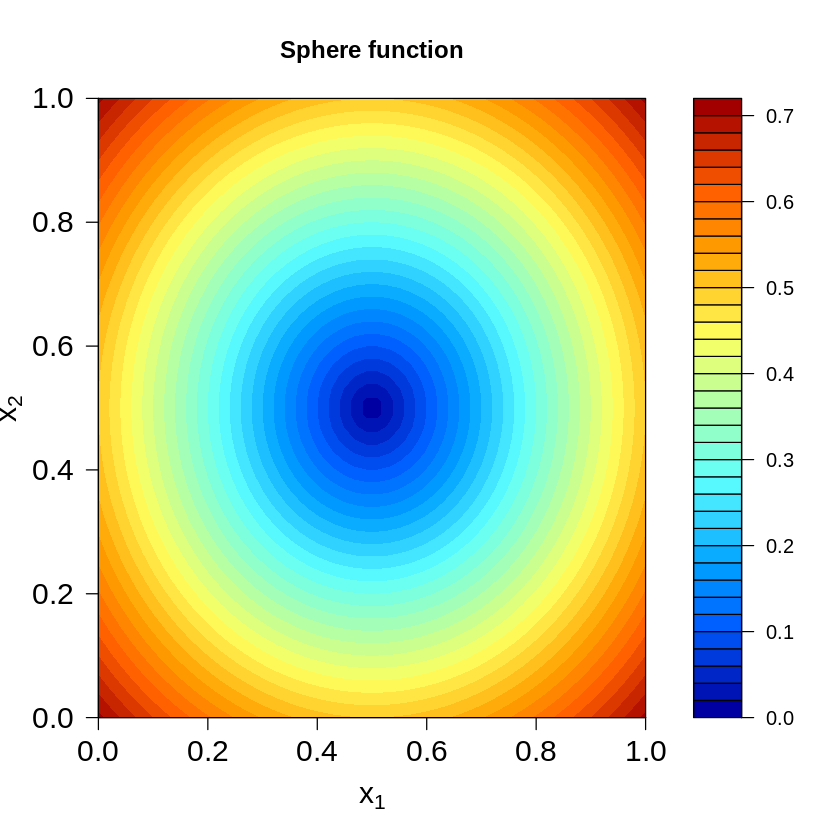

In [33]:
# Test function: Sphere function
fun_sphere <- function(x) {
  return(sqrt(sum((x-0.5)^2)))
}

d <- 2
n_plot <- 50
X_plot <- as.matrix(expand.grid(seq(0,1,length.out=n_plot), seq(0,1,length.out=n_plot)))
Y_plot <- apply(X_plot,MARGIN=1,fun_sphere)
palette <- colorRampPalette(c("#0000A2", "#0017B9", "#002ED1", "#0046E8", "#005DFF", "#0074FF", "#008BFF", "#00A2FF", "#17B9FF", "#2ED1FF", "#46E8FF", "#5DFFFF", "#74FFE8", "#8BFFD1", "#A2FFB9", "#B9FFA2", "#D1FF8B", "#E8FF74", "#FFFF5D", "#FFE846", "#FFD12E", "#FFB917", "#FFA200", "#FF8B00", "#FF7400", "#FF5D00", "#E84600", "#D12E00", "#B91700", "#A20000"))
par(mfrow=c(1,1))
filled.contour(matrix(Y_plot, n_plot, n_plot), xlim=0:1, ylim=0:1, nlevels=30, color.palette = palette,
               xlab=expression(x[1]), ylab=expression(x[2]), main="2D Sphere function",
               plot.axes={axis(1, cex.axis=1.5); axis(2, cex.axis=1.5)}, cex.lab=1.5)

## EGO avec Krigeage classique

In [34]:
set.seed(123) #Set the random seed

d <- 10 #Dimension
n_train_init <- 20 #Number of training samples
n_steps <- 50
n_tree_levels <- 5 #Number of levels for the binary tree combinations
n_comb_max <- 2^(n_tree_levels - 1)

time1 <- Sys.time()

# Training points LHS
X_train_init <- lhsDesign(n=n_train_init, dimension=d)$design #LHS

# Training values
Y_train_init <- apply(X_train_init, MARGIN=1, fun_sphere)

# Build the initial Kriging model using MLE
model_krg <- krg_MLE(X_train=X_train_init, Y_train=Y_train_init, bornes_opt=c(0.1,20),
                     kernel="matern5_2", theta_init=NULL, estim_mean=TRUE, nugget=NULL)

# Run EGO
EGO_krg <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_krg, bornes_theta_opt=c(0.1,20),
                   estim_mean=TRUE, combination=FALSE, optimizer="cmaes",
                   TR_type="NoTR", nugget=NULL, log_file=NULL)

time2 <- Sys.time()
time_krg <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_krg <- rep(NA, 1+n_steps)
best_sol_krg[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_krg[i+1] <- min(best_sol_krg[i], EGO_krg$Y[n_train_init+i])
}

(Ordinary Kriging) Starting EGO loop 1

(Ordinary Kriging) Starting EGO loop 2

(Ordinary Kriging) Starting EGO loop 3

(Ordinary Kriging) Starting EGO loop 4

(Ordinary Kriging) Starting EGO loop 5

(Ordinary Kriging) Starting EGO loop 6

(Ordinary Kriging) Starting EGO loop 7

(Ordinary Kriging) Starting EGO loop 8

(Ordinary Kriging) Starting EGO loop 9

(Ordinary Kriging) Starting EGO loop 10

(Ordinary Kriging) Starting EGO loop 11

(Ordinary Kriging) Starting EGO loop 12

(Ordinary Kriging) Starting EGO loop 13

(Ordinary Kriging) Starting EGO loop 14

(Ordinary Kriging) Starting EGO loop 15

(Ordinary Kriging) Starting EGO loop 16

(Ordinary Kriging) Starting EGO loop 17

(Ordinary Kriging) Starting EGO loop 18

(Ordinary Kriging) Starting EGO loop 19

(Ordinary Kriging) Starting EGO loop 20

(Ordinary Kriging) Starting EGO loop 21

(Ordinary Kriging) Starting EGO loop 22

(Ordinary Kriging) Starting EGO loop 23

(Ordinary Kriging) Starting EGO loop 24

(Ordinary Kriging) Starti

## EGO avec la combinaison

Le nombre de sous-modèles est $p=16$ (ou 5 niveaux sur l'arbre)

In [35]:
time1 <- Sys.time()

# Lower and upper bounds for sampling the length-scales
bounds_comb <- bornes_theta(d=d, X=X_train_init, kernel="matern5_2")

# Sampling the length-scales
theta_list <- sample_theta_entropy(X=X_train_init, n_comb=n_comb_max, bornes=bounds_comb,
                                   kernel="matern5_2", iso=TRUE)

# Build the initial combination
model_comb <- combined_krg(X_train=X_train_init, Y_train=Y_train_init, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0,
                           n_tree_levels=n_tree_levels, weighting_method="binLOO")

# Run EGO
EGO_comb <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_comb, estim_mean=TRUE,
                    combination=TRUE, n_tree_levels=n_tree_levels, optimizer="cmaes",
                    TR_type="NoTR", nugget=0, log_file=NULL)

time2 <- Sys.time()
time_comb <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_comb <- rep(NA, 1+n_steps)
best_sol_comb[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_comb[i+1] <- min(best_sol_comb[i], EGO_comb$Y[n_train_init+i])
}


(Combination) Starting EGO loop 1

(Combination) Starting EGO loop 2

(Combination) Starting EGO loop 3

(Combination) Starting EGO loop 4

(Combination) Starting EGO loop 5

(Combination) Starting EGO loop 6

(Combination) Starting EGO loop 7

(Combination) Starting EGO loop 8

(Combination) Starting EGO loop 9

(Combination) Starting EGO loop 10

(Combination) Starting EGO loop 11

(Combination) Starting EGO loop 12

(Combination) Starting EGO loop 13

(Combination) Starting EGO loop 14

(Combination) Starting EGO loop 15

(Combination) Starting EGO loop 16

(Combination) Starting EGO loop 17

(Combination) Starting EGO loop 18

(Combination) Starting EGO loop 19

(Combination) Starting EGO loop 20

(Combination) Starting EGO loop 21

(Combination) Starting EGO loop 22

(Combination) Starting EGO loop 23

(Combination) Starting EGO loop 24

(Combination) Starting EGO loop 25

(Combination) Starting EGO loop 26

(Combination) Starting EGO loop 27

(Combination) Starting EGO loop 28

(

## Plot évolution de la meilleure valeure trouvée

[1] "EGO time for OK : 14.3555905818939"
[1] "EGO time for combination : 37.2280197143555"


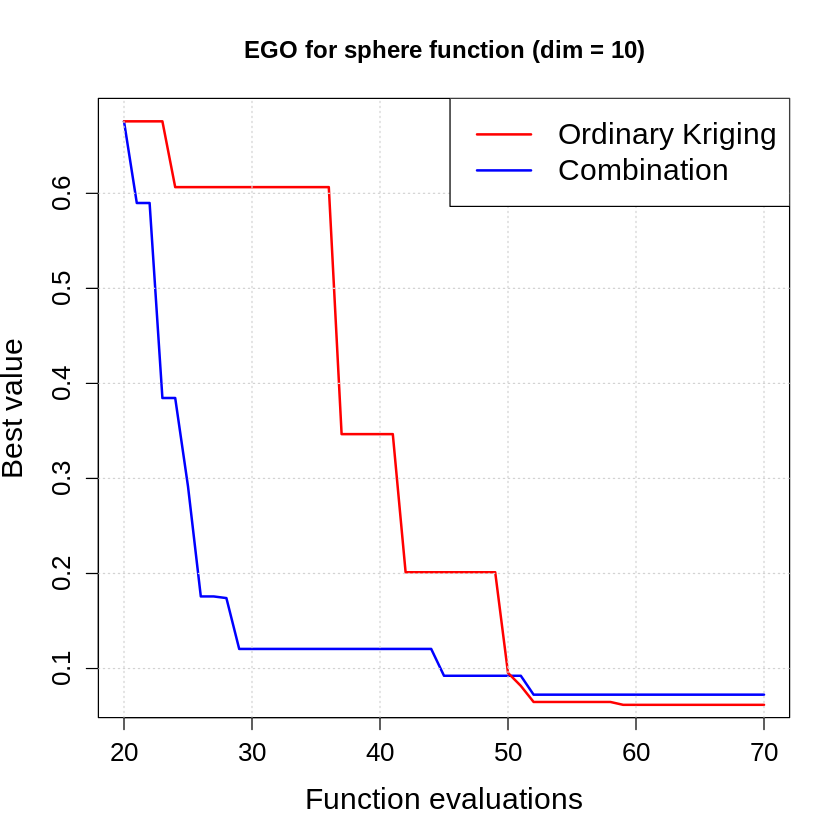

In [36]:
print(paste("EGO time for OK :",time_krg))
print(paste("EGO time for combination :",time_comb))

plot(n_train_init:(n_train_init+n_steps), best_sol_comb, type="l", col="blue", lwd=2, xlab="Function evaluations", ylab="Best value",cex.axis=1.3,cex.lab=1.5)
lines(x = n_train_init:(n_train_init+n_steps), y = best_sol_krg, type="l", col="red", lwd=2)
grid()

legend("topright", legend = c("Ordinary Kriging", "Combination"),
       col=c("red","blue"), lty=c(1,1), lwd=c(2,2), bg="white",cex=1.5)
title(main=paste("EGO for sphere function (dim = ",d,")",sep=""))


## Régions de confiance

Les résultats précédents n'utilisaient pas de région de confiance.

On peut compter le nombre de points ajoutés sur un bord du domaine au cours de l'optimisation.

In [37]:
nb_bound_krg <- 0
for (i in 1:(n_train_init+n_steps)) {
  if (min(EGO_krg$X[i,])==0 | max(EGO_krg$X[i,])==1) {
    nb_bound_krg <- nb_bound_krg + 1
  }
}

nb_bound_comb <- 0
for (i in 1:(n_train_init+n_steps)) {
  if (min(EGO_comb$X[i,])==0 | max(EGO_comb$X[i,])==1) {
    nb_bound_comb <- nb_bound_comb + 1
  }
}

print(paste("Number of points on the boundary for OK :",nb_bound_krg))
print(paste("Number of points on the boundary for the combination :",nb_bound_krg))

[1] "Number of points on the boundary for OK : 19"
[1] "Number of points on the boundary for the combination : 19"


On répète l'optimisation avec des régions de confiance (TREGO)

In [ ]:
# Build the initial Kriging model using MLE
model_krg <- krg_MLE(X_train=X_train_init, Y_train=Y_train_init, bornes_opt=c(0.1,20),
                     kernel="matern5_2", theta_init=NULL, estim_mean=TRUE, nugget=NULL)

# Run EGO
EGO_krg <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_krg, bornes_theta_opt=c(0.1,20),
                   estim_mean=TRUE, combination=FALSE, optimizer="cmaes",
                   TR_type="TREGO", nugget=NULL, log_file=NULL)

time2 <- Sys.time()
time_krg <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_krg <- rep(NA, 1+n_steps)
best_sol_krg[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_krg[i+1] <- min(best_sol_krg[i], EGO_krg$Y[n_train_init+i])
}

time1 <- Sys.time()

# Build the initial combination
model_comb <- combined_krg(X_train=X_train_init, Y_train=Y_train_init, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0,
                           n_tree_levels=n_tree_levels, weighting_method="binLOO")

# Run EGO
EGO_comb <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_comb, estim_mean=TRUE,
                    combination=TRUE, n_tree_levels=n_tree_levels, optimizer="cmaes",
                    TR_type="TREGO", nugget=0, log_file=NULL)

time2 <- Sys.time()
time_comb <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_comb <- rep(NA, 1+n_steps)
best_sol_comb[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_comb[i+1] <- min(best_sol_comb[i], EGO_comb$Y[n_train_init+i])
}

plot(n_train_init:(n_train_init+n_steps), best_sol_comb, type="l", col="blue", lwd=2, xlab="Function evaluations", ylab="Best value",cex.axis=1.3,cex.lab=1.5)
lines(x = n_train_init:(n_train_init+n_steps), y = best_sol_krg, type="l", col="red", lwd=2)
grid()
legend("topright", legend = c("Ordinary Kriging", "Combination"),
       col=c("red","blue"), lty=c(1,1), lwd=c(2,2), bg="white",cex=1.5)
title(main=paste("EGO for sphere function (dim = ",d,")",sep=""))

nb_bound_krg <- 0
for (i in 1:(n_train_init+n_steps)) {
  if (min(EGO_krg$X[i,])==0 | max(EGO_krg$X[i,])==1) {
    nb_bound_krg <- nb_bound_krg + 1
  }
}

nb_bound_comb <- 0
for (i in 1:(n_train_init+n_steps)) {
  if (min(EGO_comb$X[i,])==0 | max(EGO_comb$X[i,])==1) {
    nb_bound_comb <- nb_bound_comb + 1
  }
}

print(paste("Number of points on the boundary for OK :",nb_bound_krg))
print(paste("Number of points on the boundary for the combination :",nb_bound_krg))

## Exemple en dimension $d=30$

On augmente la dimension :

- $d=30$
- Nombre de points initiaux : $n_{train}=50$
- Nombre d'itérations EGO : $n_{iter}=50$ (peu d'itérations pour limiter le temps des tests)

(Ordinary Kriging) Starting EGO loop 1

(Ordinary Kriging) Starting EGO loop 2

(Ordinary Kriging) Starting EGO loop 3

(Ordinary Kriging) Starting EGO loop 4

(Ordinary Kriging) Starting EGO loop 5

(Ordinary Kriging) Starting EGO loop 6

(Ordinary Kriging) Starting EGO loop 7

(Ordinary Kriging) Starting EGO loop 8

(Ordinary Kriging) Starting EGO loop 9

(Ordinary Kriging) Starting EGO loop 10

(Ordinary Kriging) Starting EGO loop 11

(Ordinary Kriging) Starting EGO loop 12

(Ordinary Kriging) Starting EGO loop 13

(Ordinary Kriging) Starting EGO loop 14

(Ordinary Kriging) Starting EGO loop 15

(Ordinary Kriging) Starting EGO loop 16

(Ordinary Kriging) Starting EGO loop 17

(Ordinary Kriging) Starting EGO loop 18

(Ordinary Kriging) Starting EGO loop 19

(Ordinary Kriging) Starting EGO loop 20

(Ordinary Kriging) Starting EGO loop 21

(Ordinary Kriging) Starting EGO loop 22

(Ordinary Kriging) Starting EGO loop 23

(Ordinary Kriging) Starting EGO loop 24

(Ordinary Kriging) Starti

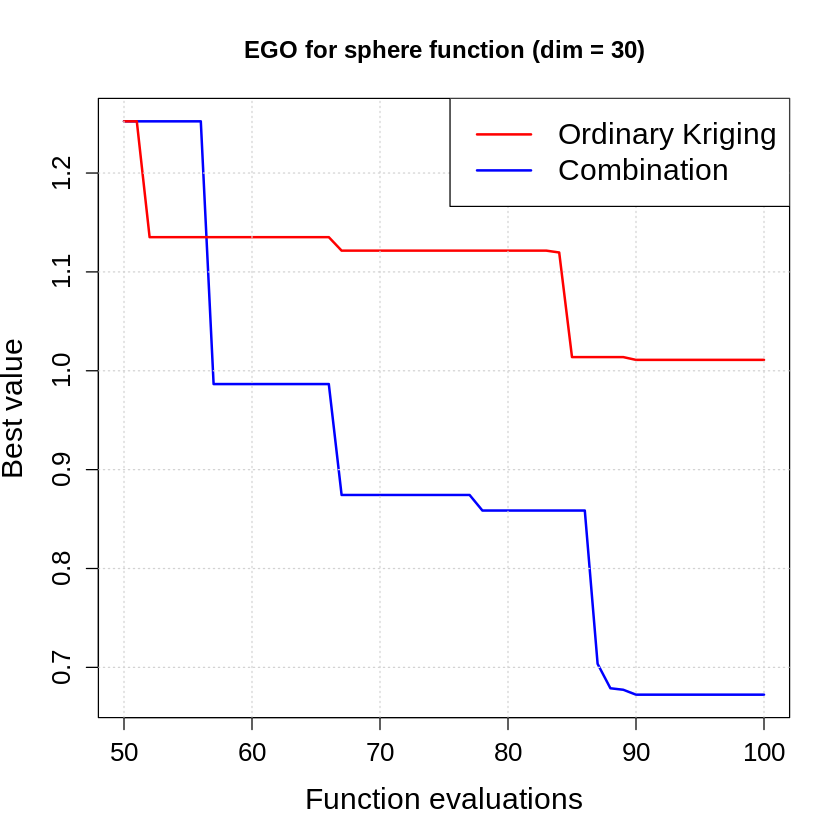

In [40]:
set.seed(123) #Set the random seed

d <- 30 #Dimension
n_train_init <- 50 #Number of training samples
n_steps <- 50
n_tree_levels <- 5 #Number of levels for the binary tree combinations
n_comb_max <- 2^(n_tree_levels - 1)

# Training points LHS
X_train_init <- lhsDesign(n=n_train_init, dimension=d)$design #LHS

# Training values
Y_train_init <- apply(X_train_init, MARGIN=1, fun_sphere)

time1 <- Sys.time()

# Build the initial Kriging model using MLE
model_krg <- krg_MLE(X_train=X_train_init, Y_train=Y_train_init, bornes_opt=c(0.1,20),
                     kernel="matern5_2", theta_init=NULL, estim_mean=TRUE, nugget=NULL)

# Run EGO
EGO_krg <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_krg, bornes_theta_opt=c(0.1,20),
                   estim_mean=TRUE, combination=FALSE, optimizer="cmaes",
                   TR_type="TREGO", nugget=NULL, log_file=NULL)

time2 <- Sys.time()
time_krg <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_krg <- rep(NA, 1+n_steps)
best_sol_krg[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_krg[i+1] <- min(best_sol_krg[i], EGO_krg$Y[n_train_init+i])
}

time1 <- Sys.time()

# Lower and upper bounds for sampling the length-scales
bounds_comb <- bornes_theta(d=d, X=X_train_init, kernel="matern5_2")

# Sampling the length-scales
theta_list <- sample_theta_entropy(X=X_train_init, n_comb=n_comb_max, bornes=bounds_comb,
                                   kernel="matern5_2", iso=TRUE)

# Build the initial combination
model_comb <- combined_krg(X_train=X_train_init, Y_train=Y_train_init, theta_list=theta_list,
                           kernel="matern5_2", estim_mean=TRUE, nugget=0,
                           n_tree_levels=n_tree_levels, weighting_method="binLOO")

# Run EGO
EGO_comb <- run_EGO(n_steps, fun=fun_sphere, X_train=X_train_init, Y_train=Y_train_init, model=model_comb, estim_mean=TRUE,
                    combination=TRUE, n_tree_levels=n_tree_levels, optimizer="cmaes",
                    TR_type="TREGO", nugget=0, log_file=NULL)

time2 <- Sys.time()
time_comb <- difftime(time2,time1,units="secs")

# Evolution of best value
best_sol_comb <- rep(NA, 1+n_steps)
best_sol_comb[1] <- min(Y_train_init)
for (i in 1:n_steps) {
  best_sol_comb[i+1] <- min(best_sol_comb[i], EGO_comb$Y[n_train_init+i])
}

plot(n_train_init:(n_train_init+n_steps), best_sol_comb, type="l", col="blue", lwd=2, xlab="Function evaluations", ylab="Best value",cex.axis=1.3,cex.lab=1.5)
lines(x = n_train_init:(n_train_init+n_steps), y = best_sol_krg, type="l", col="red", lwd=2)
grid()
legend("topright", legend = c("Ordinary Kriging", "Combination"),
       col=c("red","blue"), lty=c(1,1), lwd=c(2,2), bg="white",cex=1.5)
title(main=paste("EGO for sphere function (dim = ",d,")",sep=""))